In [1]:
pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.1 MB/s 


In [3]:
import sqlite3
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [5]:
def wrangle(db_path):
    # # Connect to database
    # conn = sqlite3.connect(db_path)

    # # Construct query
    # query = '''
    # SELECT h.*,
    #    s.*,
    #    i.vdcmun_id,
    #    d.damage_grade
    # FROM household_demographics AS h 
    # JOIN id_map AS i ON i.household_id = h.household_id
    # JOIN building_structure AS s ON i.building_id = s.building_id
    # JOIN building_damage AS d ON i.building_id = d.building_id
    # WHERE district_id = 4
    # '''
    # Read query results into DataFrame
    # df = pd.read_sql(query, conn, index_col="household_id")

    # Read Excel file
    df = pd.read_excel(db_path)

    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    drop_cols.append("building_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")
    
    # Group caste column
    top_10 = df["caste_household"].value_counts().head(10).index
    df["caste_household"] = df["caste_household"].apply(lambda c: c if c in top_10 else "Other")
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

In [6]:
df = wrangle("/content/data_2.xlsx")
df.head()

,Unnamed: 0,household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,age_building,...,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,vdcmun_id,severe_damage
0,1,16400201,Female,46,Chhetree,Class 5,Rs. 10-20 thousand,4,1,20,...,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
1,2,16408101,Male,66,Chhetree,Illiterate,Rs. 10 thousand,5,0,21,...,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
2,3,16408901,Male,54,Magar,Class 4,Rs. 10 thousand,5,1,18,...,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
3,4,16409801,Male,36,Chhetree,Class 5,Rs. 10 thousand,6,1,45,...,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
4,5,16410301,Female,39,Chhetree,Class 4,Rs. 10 thousand,3,0,21,...,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0


In [7]:
# Check for high- and low-cardinality categorical features
df.select_dtypes("object").nunique()

gender_household_head              2
caste_household                   11
education_level_household_head    19
income_level_household             5
land_surface_condition             3
foundation_type                    5
roof_type                          3
ground_floor_type                  5
other_floor_type                   4
position                           4
plan_configuration                10
superstructure                    11
dtype: int64

In [8]:
df["caste_household"].nunique()

11

In [9]:
target = "severe_damage"
X = df.drop(columns = [target, "vdcmun_id"])
y = df[target]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state=42
)

In [11]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.63


In [12]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=10000)
)
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['gender_household_head', 'caste_household',
                                     'education_level_household_head',
                                     'income_level_household',
                                     'land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=10000))])

In [13]:
acc_train = model_lr.score(X_train, y_train)
acc_test = model_lr.score(X_test, y_test)

print("LR Training Accuracy:", acc_train)
print("LR Validation Accuracy:", acc_test)

LR Training Accuracy: 0.6289987810101143
LR Validation Accuracy: 0.6391908809382618


In [14]:
features = model_lr.named_steps["onehotencoder"].get_feature_names()
importances = model_lr.named_steps["logisticregression"].coef_[0]
feat_imp = pd.Series(np.exp(importances), index=features).sort_values()
feat_imp.head()

plinth_area_sq_ft       1.0
height_ft_pre_eq        1.0
ground_floor_type_RC    1.0
roof_type_RCC/RB/RBC    1.0
foundation_type_RC      1.0
dtype: float64

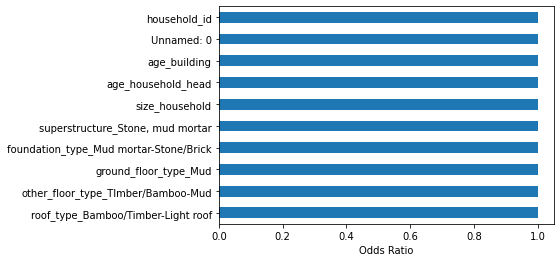

In [15]:
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Odds Ratio");

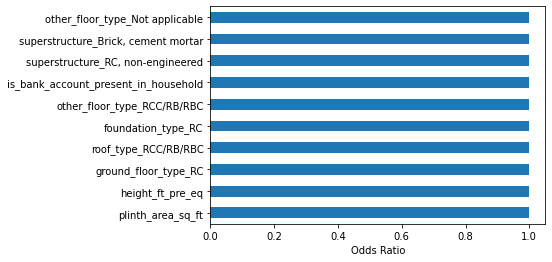

In [16]:
feat_imp.head(10).plot(kind="barh")
plt.xlabel("Odds Ratio");

In [17]:
damage_by_vdcmun = (
    df.groupby("vdcmun_id")["severe_damage"].mean().sort_values(ascending=False)
).to_frame()
damage_by_vdcmun

,severe_damage
vdcmun_id,
31,0.930199
32,0.851117
35,0.827145
30,0.824201
33,0.782464
34,0.666979
39,0.572344
40,0.512444
38,0.506425


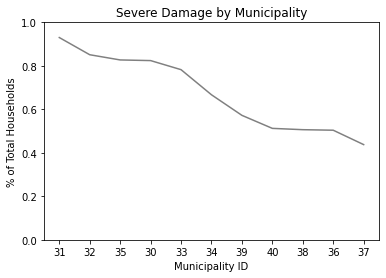

In [18]:
# Plot line
# damage_by_vdcmun.plot(kind="bar")
plt.plot(damage_by_vdcmun.values, color="grey")
plt.xticks(range(len(damage_by_vdcmun)), labels=damage_by_vdcmun.index)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Severe Damage by Municipality");

In [19]:
(
    df[df["caste_household"] == "Gurung"].groupby("vdcmun_id")["severe_damage"].count()
    / df.groupby("vdcmun_id")["severe_damage"].count()
)

vdcmun_id
30    0.338152
31    0.326937
32    0.387849
33    0.011943
34    0.385084
35    0.826889
36    0.143178
37    0.050485
38    0.049023
39    0.097971
40    0.246727
Name: severe_damage, dtype: float64

In [20]:
damage_by_vdcmun["Gurung"] = (
    df[df["caste_household"] == "Gurung"].groupby("vdcmun_id")["severe_damage"].count()
    / df.groupby("vdcmun_id")["severe_damage"].count()
)

In [21]:
damage_by_vdcmun

,severe_damage,Gurung
vdcmun_id,,
31,0.930199,0.326937
32,0.851117,0.387849
35,0.827145,0.826889
30,0.824201,0.338152
33,0.782464,0.011943
34,0.666979,0.385084
39,0.572344,0.097971
40,0.512444,0.246727
38,0.506425,0.049023


In [24]:
damage_by_vdcmun["Kumal"] = (
    df[df["caste_household"] == "Kumal"].groupby("vdcmun_id")["severe_damage"].count()
    / df.groupby("vdcmun_id")["severe_damage"].count()
).fillna(0)

In [25]:
damage_by_vdcmun

,severe_damage,Gurung,Kumal
vdcmun_id,,,
31,0.930199,0.326937,0.000000
32,0.851117,0.387849,0.000000
35,0.827145,0.826889,0.000000
30,0.824201,0.338152,0.000000
33,0.782464,0.011943,0.029478
34,0.666979,0.385084,0.000000
39,0.572344,0.097971,0.000267
40,0.512444,0.246727,0.036973
38,0.506425,0.049023,0.100686


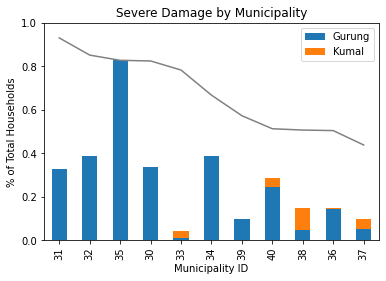

In [26]:
damage_by_vdcmun.drop(columns="severe_damage").plot(
    kind="bar", stacked=True
)

plt.plot(damage_by_vdcmun["severe_damage"].values, color="grey")
plt.xticks(range(len(damage_by_vdcmun)), labels=damage_by_vdcmun.index)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Severe Damage by Municipality");